# Nice Ride MN Exploratory Data Analysis

description / intro...

In [30]:
# Packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Matplotlib settings
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
sns.set()

# Bokeh settings
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.models import ColumnDataSource, Circle, HoverTool, ColorBar, LinearColorMapper
from bokeh.palettes import Viridis256
from bokeh.tile_providers import CARTODBPOSITRON_RETINA
fig_height = 500
fig_width = 800
output_notebook()

Loading BokehJS ...

## Data Loading and Cleaning

First, let's load the data and take a look at the data to see if it needs any cleaning.

In [ ]:
# Load data
stations = pd.read_csv('../input/Nice_Ride_2017_Station_Locations.csv')
trips = pd.read_csv('../input/Nice_ride_trip_history_2017_season.csv')

In [ ]:
# Show some of the stations data
stations.sample(n=5)

In [ ]:
# Print info about each column
for col in stations:
    print('\n',col,'\nNulls:',stations[col].isnull().sum(),'\n',stations[col].describe())

The stations dataset looks pretty clean - no missing values, and the latitude, longitude, and number of docks loaded as expected.  The only anomaly was that the last station ID number was a string ('NRHQ'), while all the others were integers.  But that's fine - pandas will just treat that column as a categorical object, which is what we want anyway.  

What about the trip data?

In [ ]:
# Show some of the trip data
trips.sample(n=5)

In [ ]:
# Print info about each column
for col in trips:
    print('\n',col,'\nNulls:',trips[col].isnull().sum(),'\n',trips[col].describe())

The trips dataset looks pretty clean too.  The only anomalies I noticed were that there are three possible Account types, and the dates were loaded as objects.

The possible types of accounts are "Member", "Casual" (which presumably just means non-member), and "Inconnu" (which I assume represents ["unknown"](https://en.wiktionary.org/wiki/inconnu#French) and not [the fish](https://en.wiktionary.org/wiki/inconnu#English)!).  But there were only two entries w/ an account type of "Inconnu", so we'll just set those entries to be "Casual" so that we only have members and non-members.

In [ ]:
# Plot types of accounts in the trips dataset
ax = sns.countplot(x='Account type', data=trips)
plt.title('Account types')
for p in ax.patches:
    x = p.get_bbox().get_points()[:,0]
    y = p.get_bbox().get_points()[1,1]
    ax.annotate('%d' % (y), (x.mean(), y), ha='center', va='bottom')
plt.show()

In [ ]:
# Set "Inconnu" memberships to "Casual"
trips.loc[trips['Account type']=='Inconnu', 'Account type'] = 'Casual'

Another small probem with the trips datset was that the trip start and end dates were loaded as generic objects, instead of dates.  Since we'll want to work with them as date/times, we'll convert them to the datetime datatype:

In [ ]:
# Convert start and end times to datetime
for col in ['End date', 'Start date']:
    trips[col] = pd.to_datetime(trips[col])

## Station Locations

Let's plot the station locations on a map.  We'll use [Bokeh](https://bokeh.pydata.org/en/latest/) to display a map of the station locations.  To plot them on a map, however, we'll first have to transform the station locations from latitude+longitude coordinates to [Mercator (UTM) coordinates](https://en.wikipedia.org/wiki/Universal_Transverse_Mercator_coordinate_system), and make a function which generates a plot of points on the map.

In [ ]:
def lat_to_mercY(lat):
    """Convert Latitude to Mercator Y"""
    return np.log(np.tan(np.pi / 4 + np.radians(lat) / 2)) * 6378137.0

def lon_to_mercX(lon):
    """Convert Longitude to Mercator X"""
    return np.radians(lon) * 6378137.0

def MapPoints(lat, lon, size=10, color="green", alpha=0.8, padding=0.1, 
              tooltips=None, title=None, width=None, height=None):
    """Bokeh plot of points overlayed on a map"""
    
    # Convert lat,lon to UTM coordinates
    X = lon_to_mercX(lon)
    Y = lat_to_mercY(lat)
    
    # Set marker sizes
    if type(size) is int or type(size) is float:
        size = size*np.ones(len(lat))
    
    # Data source table for Bokeh
    source = ColumnDataSource(data=dict(
        X = X,
        Y = Y,
        size = size
    ))
    
    # Set marker colors
    if type(color) is not str: #map colors to a colormap
        source.add(color, 'color') #add to source table
        mapper = LinearColorMapper(palette=Viridis256, low=min(color), high=max(color))
        color = {'field': 'color', 'transform': mapper}
            
    # Plot the points
    p = figure(tools="pan,wheel_zoom,reset,hover,save", active_scroll="wheel_zoom")
    p.add_tile(CARTODBPOSITRON_RETINA) #set background map
    p.circle('X', 'Y', source=source, size='size', #plot each station
             fill_color=color, fill_alpha=alpha, line_color=None)
    p.axis.visible = False
    
    # Colorbar
    if type(color) is not str: #if plotting a range of colors,
        color_bar = ColorBar(color_mapper=mapper, location=(0, 0))
        p.add_layout(color_bar, 'right')
        
    # Tool tips
    if tooltips is not None:
        for T in tooltips: #add to Bokeh data source
            source.add(T[1].values.tolist(), name=T[0])
        hover = p.select_one(HoverTool) #set hover values
        hover.tooltips=[(T[0], "@"+T[0]) for T in tooltips]
        
    # Title
    if title is not None:
        p.title.text = title
        
    # Figure height
    if height is not None:
        p.plot_height = height
        
    # Figure width
    if width is not None:
        p.plot_width = width
    
    return p

In [ ]:
# On hover, show Station name and the number of docks
tooltips = [("Station", stations['Name']), 
            ("Docks", stations['Total docks'])]

# Plot the stations
p = MapPoints(stations.Latitude, stations.Longitude, 
              tooltips=tooltips, color=stations['Total docks'],
              title="Nice Ride Locations (color indicates # docks)",
              height=fig_height, width=fig_width)

show(p)

## Station Demand

Let's also take a look at the demand at each station.  What I mean by that is the number of bikes which users take from each station and leave at each station.  By grouping by the station name and counting, we can find how many trips have left from or ended at each station.

In [ ]:
# Count incoming and outgoing trips for each station
demand_df = pd.DataFrame({'Outgoing trips': trips.groupby('Start station').size(),
                          'Incoming trips': trips.groupby('End station').size()
                      })
demand_df['Name'] = demand_df.index
sdf = stations.merge(demand_df, on='Name')

How many trips are started from each station?  We'll take a look at the distribution (as a histogram) and then plot the number of trips started from each station on a map.

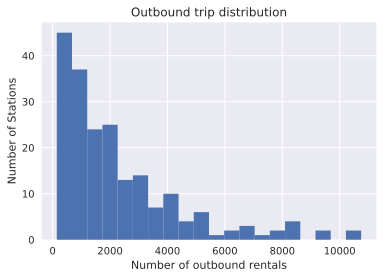

In [62]:
# Plot num trips started from each station 
plt.figure()
plt.hist(sdf['Outgoing trips'], bins=20)
plt.ylabel('Number of Stations')
plt.xlabel('Number of outbound rentals')
plt.title('Outbound trip distribution')
plt.show()

In [31]:
# On hover, show Station name, the number of docks, and the number of outgoing trips
tooltips = [("Station", sdf['Name']), 
            ("Docks", sdf['Total docks']),
            ("Num_Outgoing", sdf['Outgoing trips'])]

# Plot the stations
p = MapPoints(sdf.Latitude, sdf.Longitude, 
              tooltips=tooltips, color=sdf['Outgoing trips'],
              title="Nice Ride Locations (color indicates # Outgoing trips)",
              height=fig_height, width=fig_width)

show(p)

And the number of trips which *end* at each station?

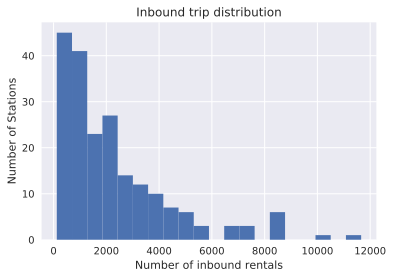

In [63]:
# Plot num trips started from each station 
plt.figure()
plt.hist(sdf['Incoming trips'], bins=20)
plt.ylabel('Number of Stations')
plt.xlabel('Number of inbound rentals')
plt.title('Inbound trip distribution')
plt.show()

In [66]:
# Sanity / valid data check
print('Number of outbound trips: %d' % (sdf['Outgoing trips'].sum()))
print('Number of inbound trips: %d' % (sdf['Incoming trips'].sum()))

Number of outbound trips: 460718
Number of inbound trips: 460718


In [32]:
# On hover, show Station name, the number of docks, and the number of INCOMING trips
tooltips = [("Station", sdf['Name']), 
            ("Docks", sdf['Total docks']),
            ("Num_Incoming", sdf['Incoming trips'])]

# Plot the stations
p = MapPoints(sdf.Latitude, sdf.Longitude, 
              tooltips=tooltips, color=sdf['Incoming trips'],
              title="Nice Ride Locations (color indicates # Incoming trips)",
              height=fig_height, width=fig_width)

show(p)

Nice Ride MN has to re-distribute bikes from stations which have extra bikes to stations which don't have enough.  Stations which have more rides ending at that station than starting there will end up with extra bikes, and Nice Ride will have to re-distribute those extra bikes to the stations which are more empty!  What does this distribution look like? That is, which stations have more rides ending at that station than starting there, or vice versa?  Again we'll use Bokeh to plot this difference in demand.

In [33]:
# Compute the DIFFERENCE between #incoming and #outgoing trips
sdf['demand_diff'] = sdf['Incoming trips']-sdf['Outgoing trips']

# On hover, show Station name, #docks, and DIFFERENCE between #incoming and #outgoing trips
tooltips = [("Station", sdf['Name']), 
            ("Docks", sdf['Total docks']),
            ("Incoming_minus_Outgoing", sdf['demand_diff'])]

# Plot the stations
p = MapPoints(sdf.Latitude, sdf.Longitude, 
              tooltips=tooltips, color=sdf['demand_diff'],
              title="Nice Ride Locations (color indicates #Incoming - #Outgoing trips)",
              height=fig_height, width=fig_width)

show(p)

There's clearly some stations at which more people are ending their trips than starting (e.g. the station at Lake St & Knox Ave, at the northeast corner of lake Bde Maka Ska), and also stations at which more people are *starting* their trips than ending (e.g. the station at Coffman Union on the Univeristy of Minnesota campus).  Is this difference in demand going to be a problem for Nice Ride?

 Ideally, Nice Ride will want to have more docks at stations where there is large difference between the number of incoming and outgoing rides.  This is because if more rides are starting at a given station than ending there, the number of bikes at that station will decrease as the day goes on.  So, there need to be enough docks at that station to hold enough bikes so the station isn't empty by the end of the day!  On the other hand, if more rides are *ending* at a station than are beginning there, all the docks at that station will fill up and people won't be able to end their rides there!

Stations which have a good balance of the number of rides coming in to the number of rides going out don't need quite as many docks - because about as many bikes are being taken from that station as are being left there.  Although, there's also the issue of time (some stations may see different demand depending on the time of day, week, or season). With a good match of the number of docks at each station to the difference between incoming and outgoing trips, Nice Ride won't have to spend as much time during prime riding hours re-distributing bikes from low-demand stations (with extra unused bikes) to high-demand stations (with not enough bikes!).  How well does this distribution of demand differences match up with the distribution of the number of docks at each station? 

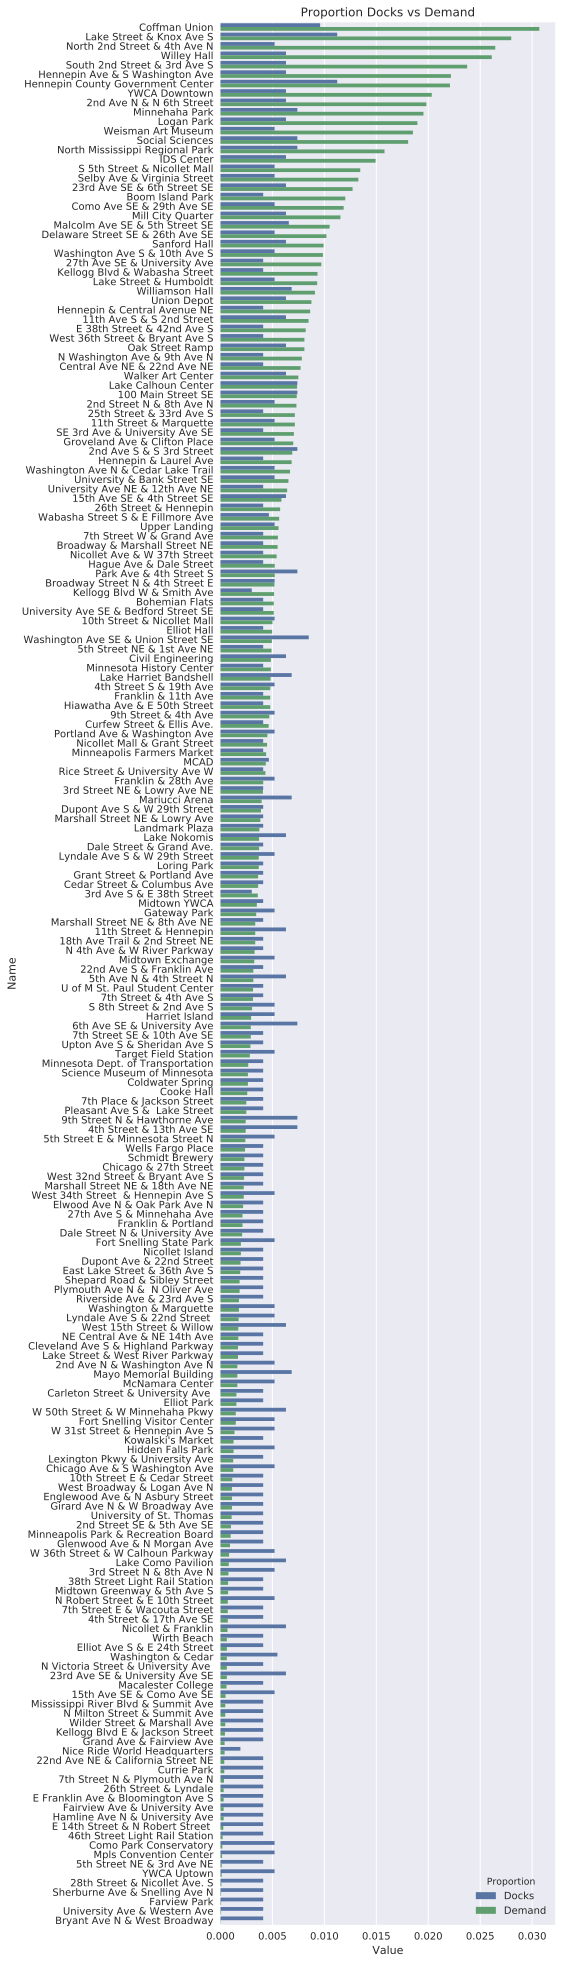

In [56]:
# Compute the ABSOLUTE difference between #incoming and #outgoing trips
sdf['abs_diff'] = sdf['demand_diff'].abs()

# Distributions of docks and absolute demand difference across stations
sdf['Docks'] = sdf['Total docks']/sdf['Total docks'].sum()
sdf['Demand'] = sdf['abs_diff']/sdf['abs_diff'].sum()

# Demand direction (more outgoing vs incoming)
sdf['demand_dir'] = sdf['Name']
sdf.loc[sdf['demand_diff']<0, 'demand_dir'] = 'More Outgoing'
sdf.loc[sdf['demand_diff']>0, 'demand_dir'] = 'More Incoming'
sdf.loc[sdf['demand_diff']==0, 'demand_dir'] = 'Balanced'

# Tidy the data for seaborn
tidified = (
    sdf[['Name', 'Docks', 'Demand']]
       .set_index('Name')
       .stack()
       .reset_index()
       .rename(columns={'level_1': 'Proportion', 0: 'Value'})
)

# Show the distributions
plt.figure(figsize=(6, 35))
sns.barplot(y='Name', x='Value', hue='Proportion', data=tidified,
            order=sdf.sort_values('Demand', ascending=False)['Name'].tolist())
plt.title('Proportion Docks vs Demand')
plt.show()

# Notes / TODO

Data cleaning first

Use KeplerGL maybe to visualize:
- Station locations and spots per station
- Ride density to and from stations, and vs time
- Difference in to vs from, and vs time (need to know where to move bikes)
- Flow (overall)
- Flow to vs from
- Flow to and from by day/time
  - Eg to/from downtown on a weekday morning vs night
  - Or to/from the lakes/parks weekday vs weekend
  
Compute # bikes at each station? If that's not provided
- Then visualize bike availability vs station

Does the distribution of rides from a each station match the distribution of available bikes at each station? (This will change over time, see if there's a time when it's especially bad)

Does the distribution of rides to each station match the distribution of empty slots (again will change over time)

Is there a difference in the bike patterns between people with a membership vs people without one?
- Compute the transition (or trip) probability matrix for members and separately for non members
- Does it significantly differ?
- Or could bootstrap to get distributions for each trip, compute roc to get prob members take that trip more often (don't bother with significance testing unless there's one or two you are really interested in...)
- Then find the M best stations to put ads at (the M stations which maximize the probability that a person with a riding pattern similar to people with memberships will see it)
- Mention that this assumes that people who have bike patterns that are similar to those people with memberships are more likely to actually get memberships. And say that in fact what you would really want to do is do a/b testing or Bandit algorithm.

How does riding activity depend on the weather?
 -Temperature, cloudy, and rain
 
Is there a seasonal dependence in riding activity independent of the weather?
- Look at residuals over season after regressing out weather
- The idea is: do people just not wanna ride bikes as much in the fall even if it's nice out?
